# Demonstration of MUSE

This is a demonstration of MUSE analysis on a multi-modality simulated data.

Altschuler & Wu Lab 2020.

Software provided as is under MIT License.

## Import packages

In [1]:
import test_package.muse as mu
import simulation_tool.multi_modal_simulation as simulation
import phenograph
from sklearn.decomposition import PCA
import numpy as np
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mofapy2.run.entry_point import entry_point
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

np.random.seed(2020)

## Generate simulation data

Simulation parameters

In [2]:
latent_dim = 100
num_cluster = 10
sample_size = 1000
latent_code_dim = 30
observed_data_dim = 500
sigma_1 = 0.1  
sigma_2 = 0.1  
decay_coef_1 = 0.5 
decay_coef_2 = 0.1
merge_prob = 0.7

Use simulation tool to generate multi-modality data

In [3]:
data = simulation.multi_modal_simulator(num_cluster, sample_size,
                                        observed_data_dim, observed_data_dim,
                                        latent_code_dim,
                                        sigma_1, sigma_2,
                                        decay_coef_1, decay_coef_2,
                                        merge_prob)
data_a = data['data_a_dropout']
data_b = data['data_b_dropout']
label_a = data['data_a_label']
label_b = data['data_b_label']
label_true = data['true_cluster']

## Analyses based on single modality-alone

Learn features from single modality

In [4]:
view_a_feature = PCA(n_components=latent_dim).fit_transform(data_a)
view_b_feature = PCA(n_components=latent_dim).fit_transform(data_b)

Perform clustering using PhenoGraph

In [5]:
view_a_label, _, _ = phenograph.cluster(view_a_feature)
view_b_label, _, _ = phenograph.cluster(view_b_feature)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.2520771026611328 seconds
Jaccard graph constructed in 0.6937308311462402 seconds
Wrote graph to binary file in 0.20174622535705566 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.565656
Louvain completed 21 runs in 0.8051540851593018 seconds
PhenoGraph complete in 1.993478536605835 seconds
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.22737717628479004 seconds
Jaccard graph constructed in 0.730170726776123 seconds
Wrote graph to binary file in 0.09156107902526855 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.607026
Louvain completed 21 runs in 0.8923578262329102 seconds
PhenoGraph complete in 1.9691593647003174 seconds


## Combined analysis using MUSE

MUSE learns the joint latent representation

In [6]:
muce_feature, reconstruct_x, reconstruct_y, \
latent_x, latent_y = mu.muse_fit_predict(data_a,
                                         data_b,
                                         label_a,
                                         label_b,
                                         latent_dim=100,
                                         n_epochs=500,
                                         lambda_regul=5,
                                         lambda_super=5)

MUSE initialization
epoch: 0, 	 total loss: 1964.42725,	 reconstruction loss: 957.92572,	 sparse penalty: 201.30032
epoch: 50, 	 total loss: 1107.76660,	 reconstruction loss: 156.39325,	 sparse penalty: 190.27466
epoch: 0, 	 total loss: 1099.35120,	 reconstruction loss: 156.39641,	 sparse penalty: 179.13782,	 x triplet: 4.60615,	 y triplet: 4.84699
epoch: 50, 	 total loss: 1000.63037,	 reconstruction loss: 156.40358,	 sparse penalty: 168.31882,	 x triplet: 0.28748,	 y triplet: 0.23906
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.2342073917388916 seconds
Jaccard graph constructed in 1.8210728168487549 seconds
Wrote graph to binary file in 0.33324623107910156 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.86829
Louvain completed 21 runs in 1.6154000759124756 seconds
PhenoGraph complete in 4.017857789993286 seconds
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbor

PhenoGraph clustering

In [7]:
muce_label, _, _ = phenograph.cluster(muce_feature)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.1298682689666748 seconds
Jaccard graph constructed in 1.8115949630737305 seconds
Wrote graph to binary file in 0.1179208755493164 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.919966
Louvain completed 21 runs in 1.605050802230835 seconds
PhenoGraph complete in 3.677513360977173 seconds


## Visualization of latent spaces 
Latent spaces of single-modality features or MUSE features were visualized using tSNE, with ground truth cluster labels.

Cluster accuries were quantified using adjusted Rand index (ARI). ARI = 1 indicates perfectly discover true cell identities.

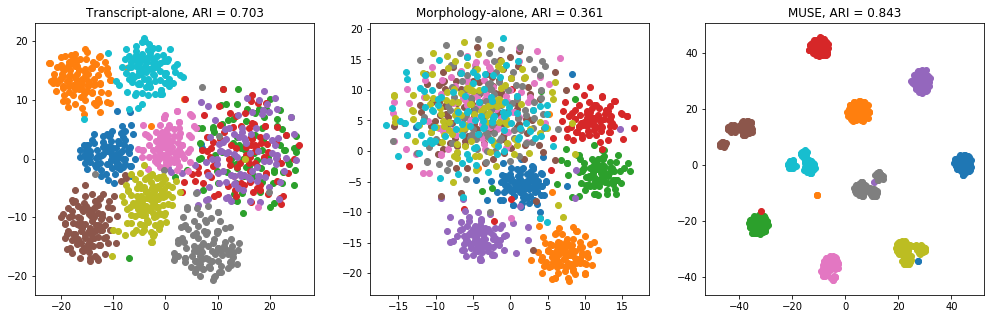

In [8]:
plt.figure(figsize=(17, 5))
plt.subplot(1, 3, 1)
X_embedded = TSNE(n_components=2).fit_transform(view_a_feature)
for i in np.unique(label_true):
    idx = np.nonzero(label_true == i)[0]
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1])
    plt.title('Transcript-alone, ARI = %01.3f' % adjusted_rand_score(label_true, view_a_label))

plt.subplot(1, 3, 2)
X_embedded = TSNE(n_components=2).fit_transform(view_b_feature)
for i in np.unique(label_true):
    idx = np.nonzero(label_true == i)[0]
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1])
    plt.title('Morphology-alone, ARI = %01.3f' % adjusted_rand_score(label_true, view_b_label))

plt.subplot(1, 3, 3)
X_embedded = TSNE(n_components=2).fit_transform(muce_feature)
for i in np.unique(label_true):
    idx = np.nonzero(label_true == i)[0]
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1])
    plt.title('MUSE, ARI = %01.3f' % adjusted_rand_score(label_true, muce_label))